# Submitted by Tarang Ranpara (202011057)

## Exploring Data

In [1]:
! unzip data.zip

Archive:  data.zip
   creating: .data/PennTreebank/
  inflating: .data/PennTreebank/ptb.test.txt  
  inflating: .data/PennTreebank/ptb.train.txt  
  inflating: .data/PennTreebank/ptb.valid.txt  


In [2]:
# dataset files 
train_file = '.data/PennTreebank/ptb.train.txt'
test_file  = '.data/PennTreebank/ptb.test.txt'
valid_file = '.data/PennTreebank/ptb.valid.txt'

In [3]:
# checking the content of each file
def check_content(files):
    for file in files:
        print(f'file: {file}')
        with open(file, 'r') as fle:
            lines = fle.readlines()[:3]
            for line in lines:
                print(line)
        print('..................\n')

check_content([train_file, test_file, valid_file])

file: .data/PennTreebank/ptb.train.txt
 aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter 

 pierre <unk> N years old will join the board as a nonexecutive director nov. N 

 mr. <unk> is chairman of <unk> n.v. the dutch publishing group 

..................

file: .data/PennTreebank/ptb.test.txt
 no it was n't black monday 

 but while the new york stock exchange did n't fall apart friday as the dow jones industrial average plunged N points most of it in the final hour it barely managed to stay this side of chaos 

 some circuit breakers installed after the october N crash failed their first test traders say unable to cool the selling panic in both stocks and futures 

..................

file: .data/PennTreebank/ptb.valid.txt
 consumers may want to move their telephones a little closer to the tv set 

 <unk> <unk> watching abc 's monday night football can now v

In [4]:
# exploring each file to know max word & seq length 
def find_max_lens(files):
    max_word_length = 0
    max_seq_length = 0
    for file in files:
        with open(file, 'r') as fle:
            lines = fle.readlines()
            for line in lines:
              line = line.strip().split()
              if len(line) > max_seq_length:
                  max_seq_length = len(line)

              for word in line:
                  if(len(word) > max_word_length):
                      max_word_length = len(word)

    return max_seq_length, max_word_length

max_seq_length, max_word_length = find_max_lens([train_file, test_file, valid_file])
print(f'max observed seq length: {max_seq_length}')
print(f'max observed word length: {max_word_length}')

max observed seq length: 82
max observed word length: 19


## Defining Data Loaders 

In [5]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, TimeDistributed, Concatenate, Dense

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [6]:
class DataLoader(Sequence):
    
    '''
      path: path to input file
      batch_size: size of batch
      num_classes: number of unique postags in dataset 
    '''
    def __init__(self, path, batch_size=1, num_classes=None):
        # user provided params 
        self.path = path 
        self.batch_size = batch_size

        # configurable params  (according to the dataset we're using)
        self.oov_token = '<unk>'
        self.padding_type="post"
        self.trunc_type="post"
        
        # after observing the data above (82, 19 respectively)
        self.max_word_seq_len = 100
        self.max_char_seq_len = 40

        # gets list of sentences 
        self.sentences = self._get_sentences()

        # computes indexes of sentences 
        self.indexes = np.arange(len(self.sentences))

        # defining tokenizers 
        self.word_tokenizer = self._fit_tokenizer(False, True, self.sentences)
        self.char_tokenizer = self._fit_tokenizer(True, True, self.sentences)

        self.postags = self._get_postags()
        self.postag_tokenizer = self._fit_tokenizer(False, False, self.postags)
        
        # vocab sizes
        self.word_vocab_size = len(self.word_tokenizer.word_index) + 1
        self.char_vocab_size = len(self.char_tokenizer.word_index) + 1
        self.postag_vocab_size = len(self.postag_tokenizer.word_index) + 1

        # to consider rare occurance when test/valid doesn't contain all the classes 
        self.num_classes = self.postag_vocab_size if num_classes == None else num_classes

        # padded sequences
        self.padded_word_sequences = self._get_padded_output(self.sentences, self.word_tokenizer)
        self.padded_char_sequences = self._get_padded_output(self.sentences, self.char_tokenizer)
        self.padded_postag_sequences = self._get_padded_output(self.postags, self.postag_tokenizer)

        # Shuffle dataset
        self.on_epoch_end()

    # gets list of sentences from given file 
    def _get_sentences(self):
        with open(self.path, 'r') as fle:
            lines = fle.readlines()
            res = []
            for line in lines:
                line = line.strip().lower()
                res.append(line)
        return res  

    '''
    fits and returns given type of tokenizer
      char_level: true for chal level tokenization 
      lower: true if we want to convert text in lower 
      data: data for tokenizer
    '''
    def _fit_tokenizer(self, char_level, lower, data):
        tokenizer = Tokenizer(oov_token=self.oov_token, char_level=char_level, lower=lower)
        tokenizer.fit_on_texts(data)
        return tokenizer

    '''
    computes postags for given tokens and 
    outputs lines containing postags for respective tokens 
    '''
    def _get_postags(self):
        postags = []
        for sent in self.sentences:
            words = self.word_tokenizer.sequences_to_texts(self.word_tokenizer.texts_to_sequences([sent]))[0].split()
            predicted_postags = nltk.pos_tag(words)
            postags.append(
                ' '.join(pos for word, pos in predicted_postags)
            )

        return postags

    '''
      computes padded sequence for given sequence (word/chars)
      input_sents: list of sequences 
      tokenizer: word/char tokenizer 
    '''
    def _get_padded_output(self, input_sents, tokenizer):
        if tokenizer is self.char_tokenizer:
            padded_seqs = self._get_padded_char_sequences(input_sents, tokenizer)
        else:
            padded_seqs = self._get_padded_sequences(input_sents, tokenizer)
        return padded_seqs

    '''
      computes padded sequence for given sequence (word)
      input_sents: list of sequences 
      tokenizer: word tokenizer 
    '''
    def _get_padded_sequences(self, input_sents, tokenizer):
        # text -> text ids 
        tokenized_seqs = tokenizer.texts_to_sequences(input_sents)
        
        # pad sequences as per pre-defined max_word_seq_len
        padded_seqs = pad_sequences(
            # word sequences (tokens)
            tokenized_seqs,

            # max seq length
            maxlen=self.max_word_seq_len,

            # both are set to 'post'
            padding=self.padding_type,
            truncating=self.trunc_type
        )
        return padded_seqs

    '''
      computes padded sequence for given sequence (chars)
      input_sents: list of sequences 
      tokenizer: char tokenizer 
    '''
    def _get_padded_char_sequences(self, input_sents, tokenizer):
        padded_word_seqs = self._get_padded_sequences(input_sents, self.word_tokenizer)
        padded_sents = self.word_tokenizer.sequences_to_texts(padded_word_seqs)
        
        tokenized_padded_seqs = []
        for sent in padded_sents:
            words_char_tokens = tokenizer.texts_to_sequences(sent.split())
            padded_tokens = pad_sequences(
                # char sequences (tokens)
                words_char_tokens,

                # max seq length
                maxlen=self.max_char_seq_len,

                # both are set to 'post'
                padding=self.padding_type,
                truncating=self.trunc_type
            )
            
            tokenized_padded_seqs.append(padded_tokens)

        return np.array(tokenized_padded_seqs)

    '''
    total number of batches
    '''
    def __len__(self):
        return int(np.ceil(len(self.sentences) / self.batch_size))

    '''
    returns batch of data on every iteration
    index: implicit input denoting the index of requested batch 
    '''
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        batch_words = self.padded_word_sequences[indexes]
        batch_chars = self.padded_char_sequences[indexes]
        batch_postags = self.padded_postag_sequences[indexes]

        return (batch_words, batch_chars), to_categorical(batch_postags, num_classes=self.num_classes)

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

In [7]:
# defining loaders 
batch_size = 256

# we'll decide value of 'num_classes' from this loader
# (this is what fit method would have done) 
train_loader = DataLoader(
    train_file,
    batch_size = batch_size
)

val_loader = DataLoader(
    valid_file,
    batch_size = batch_size, 
    num_classes = train_loader.postag_vocab_size
)

test_loader = DataLoader(
    test_file, 
    batch_size = batch_size, 
    num_classes = train_loader.postag_vocab_size
)

In [8]:
word_seq_len = train_loader.max_word_seq_len
char_seq_len = train_loader.max_char_seq_len
word_vocab_size = train_loader.word_vocab_size
char_vocab_size = train_loader.char_vocab_size
postag_vocab_size = train_loader.postag_vocab_size

print(f'word_seq_len: {word_seq_len}')
print(f'char_seq_len: {char_seq_len}')
print(f'word_vocab_size: {word_vocab_size}')
print(f'char_vocab_size: {char_vocab_size}')
print(f'postag_vocab_size: {postag_vocab_size}')

word_seq_len: 100
char_seq_len: 40
word_vocab_size: 9651
char_vocab_size: 50
postag_vocab_size: 36


In [9]:
# sanity check 
print(f'train words:{train_loader[0][0][0].shape}')
print(f'train chars:{train_loader[0][0][1].shape}')
print(f'train postags:{train_loader[0][1].shape}')

print('-----------------------------------------------')

print(f'val words:{val_loader[0][0][0].shape}')
print(f'val chars:{val_loader[0][0][1].shape}')
print(f'val postags:{val_loader[0][1].shape}')

print('-----------------------------------------------')

print(f'test words:{test_loader[0][0][0].shape}')
print(f'test chars:{test_loader[0][0][1].shape}')
print(f'test postags:{test_loader[0][1].shape}')

train words:(256, 100)
train chars:(256, 100, 40)
train postags:(256, 100, 36)
-----------------------------------------------
val words:(256, 100)
val chars:(256, 100, 40)
val postags:(256, 100, 36)
-----------------------------------------------
test words:(256, 100)
test chars:(256, 100, 40)
test postags:(256, 100, 36)


## POS Tagger Model 

In [10]:
def pos_tagger_model(
    vocab_sizes,
    max_seq_lens,
    embedding_dim=128,
    char_lstm_units=128,
    word_bilstm_units=128,
    mlp_units=128,
    name="POS_Tagger", 
):

    # assigning the vars
    words_vocab_size, chars_vocab_size, postags_vocab_size = vocab_sizes
    word_sequence_length, char_sequence_length = max_seq_lens

    # Input source 1 - word sequence 
    word_sequence = Input(shape=(word_sequence_length,))
    word_vectors = Embedding(words_vocab_size, embedding_dim, input_length=word_sequence_length)(word_sequence)

    # Input source 2 - char sequence for given word sequence 
    char_sequence = Input(shape=(word_sequence_length, char_sequence_length))
    char_vectors = Embedding(chars_vocab_size, embedding_dim, input_length=char_sequence_length)(char_sequence)
    char_lstm_output = TimeDistributed(LSTM(char_lstm_units))(char_vectors)
    
    # concatinating output of both sources and applying BiLSTM
    concat_output = Concatenate(axis=-1)([word_vectors, char_lstm_output])
    bilstm_output = Bidirectional(LSTM(word_bilstm_units, return_sequences=True))(concat_output)
    
    # applying multi-layer perceptron on BiLSTM output
    mlp_output = Dense(mlp_units, activation="relu")(bilstm_output)
    output = Dense(postags_vocab_size, activation="softmax")(mlp_output)

    model = Model(inputs=(word_sequence, char_sequence), outputs=output, name=name) 
    return model

In [11]:
vocab_sizes = [word_vocab_size, char_vocab_size, postag_vocab_size]
max_seq_lens = [word_seq_len, char_seq_len]
model = pos_tagger_model(vocab_sizes, max_seq_lens)

In [12]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[Precision(), Recall()])
print(model.summary())

Model: "POS_Tagger"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 40)]    0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 40, 128) 6400        input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 128)     1235328     input_1[0][0]                    
_________________________________________________________________________________________

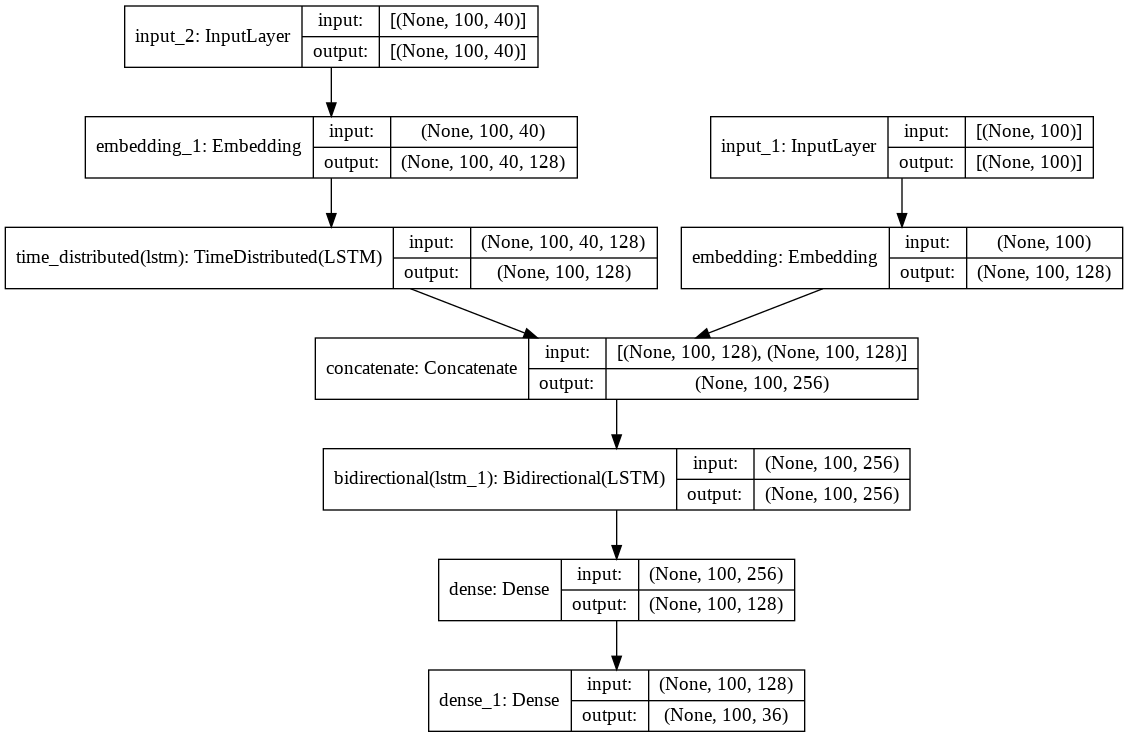

In [13]:
# visual reprentation of model architecture 
plot_model(
    model, 
    show_shapes = True, 
    show_layer_names = True
)

In [14]:
epochs = 10
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_loader, validation_data=val_loader, epochs=epochs, callbacks=[earlystopping])

Epoch 1/10
165/165 [==============================] - 150s 843ms/step - loss: 0.6762 - precision: 0.9744 - recall: 0.7649 - val_loss: 0.5752 - val_precision: 0.9507 - val_recall: 0.8321
Epoch 2/10
165/165 [==============================] - 138s 835ms/step - loss: 0.1425 - precision: 0.9887 - recall: 0.9385 - val_loss: 1.5151 - val_precision: 0.8637 - val_recall: 0.8508
Epoch 3/10
165/165 [==============================] - 137s 833ms/step - loss: 0.0517 - precision: 0.9894 - recall: 0.9814 - val_loss: 1.7709 - val_precision: 0.8594 - val_recall: 0.8514
Epoch 4/10
165/165 [==============================] - 138s 836ms/step - loss: 0.0386 - precision: 0.9911 - recall: 0.9857 - val_loss: 1.8792 - val_precision: 0.8589 - val_recall: 0.8522


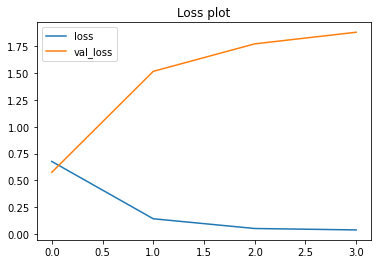

In [15]:
plt.title("Loss plot")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

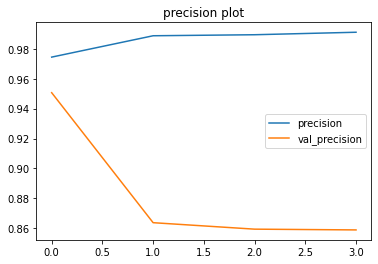

In [16]:
plt.title("precision plot")
plt.plot(history.history["precision"], label="precision")
plt.plot(history.history["val_precision"], label="val_precision")
plt.legend()
plt.show()

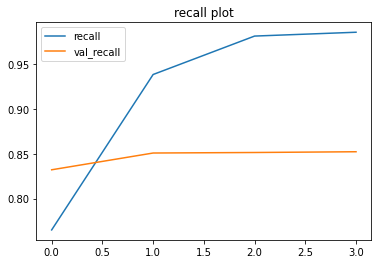

In [17]:
plt.title("recall plot")
plt.plot(history.history["recall"], label="recall")
plt.plot(history.history["val_recall"], label="val_recall")
plt.legend()
plt.show()

In [18]:
scores = model.evaluate(test_loader)

15/15 [==============================] - 4s 246ms/step - loss: 2.0103 - precision: 0.8616 - recall: 0.8549


In [19]:
precision = scores[1]
recall = scores[2]

f1_score = (2 * precision * recall) / (precision + recall)

print(f"Test F1-score: {round(f1_score, 3)}")

Test F1-score: 0.858
